# folium을 이용해서 서울시 구별 경계선 그리기

In [1]:
import pandas as pd
import folium
import json
import requests
import matplotlib.pyplot as plt
from folium import plugins
import branca.colormap as cm

In [2]:
# CSV 파일을 읽어 데이터프레임으로 변환
stations_df = pd.read_csv('서울교통공사_1_8호선_역사_좌표(위경도)정보_20231031.csv', encoding='euc-kr')
air_quality_df = pd.read_csv('서울교통공사_지하역사_공기질_측정_정보_20221231_cleaned_v2.csv')

# 두 데이터프레임을 역명으로 병합
merged_df = pd.merge(stations_df, air_quality_df, on='역명')

In [3]:
# 지도의 중심을 서울의 중앙으로 설정
map_center = [37.5665, 126.9780]
geo_json_url = 'https://raw.githubusercontent.com/southkorea/seoul-maps/master/kostat/2013/json/seoul_municipalities_geo_simple.json'
geo_json = requests.get(geo_json_url).json()

m = folium.Map(
    location=map_center, 
    zoom_start=11,
    tiles='cartodbpositron'
)

# 미세먼지 농도의 최솟값과 최댓값을 가져와서 색상바를 생성
min_pm = merged_df['미세먼지'].min()
max_pm = merged_df['미세먼지'].max()
colormap = cm.linear.Blues_09.scale(min_pm, max_pm)
colormap = colormap.to_step(index=[min_pm, (min_pm+max_pm)/2, max_pm])

# 각 역사에 원과 이름을 추가
for idx, row in merged_df.iterrows():
    folium.Circle(
        location=[row['위도'], row['경도']],
        radius=150,  # 동그라미 크기를 키우기 위해 radius 값을 더 크게 설정
        color=colormap(row['미세먼지']),
        fill=True,
        fill_color=colormap(row['미세먼지']),
        fill_opacity=0.7
    ).add_to(m)
    
    folium.Marker(
        location=[row['위도'], row['경도']],
        icon=folium.DivIcon(html=f"""<div style="font-size: 10pt; color: black;">{row['역명']}</div>""")
    ).add_to(m)

# 서울시 및 각 '구'별 경계선을 지도에 추가
folium.GeoJson(
    geo_json,
    name='geojson'
).add_to(m)

# 색상바를 추가
colormap.caption = 'PM10 Concentration (μg/m³)'
colormap.add_to(m)

# 지도를 HTML 파일로 저장
m.save('seoul_subway_air_quality.html')

# Matplotlib을 이용하여 역사 위치 및 공기질 측정 시각화하기

In [4]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.font_manager as fm

In [5]:
# GeoPandas를 사용하여 서울시 경계선 GeoDataFrame 읽기
geo_json_url = 'https://raw.githubusercontent.com/southkorea/seoul-maps/master/kostat/2013/json/seoul_municipalities_geo_simple.json'
seoul_gdf = gpd.read_file(geo_json_url)

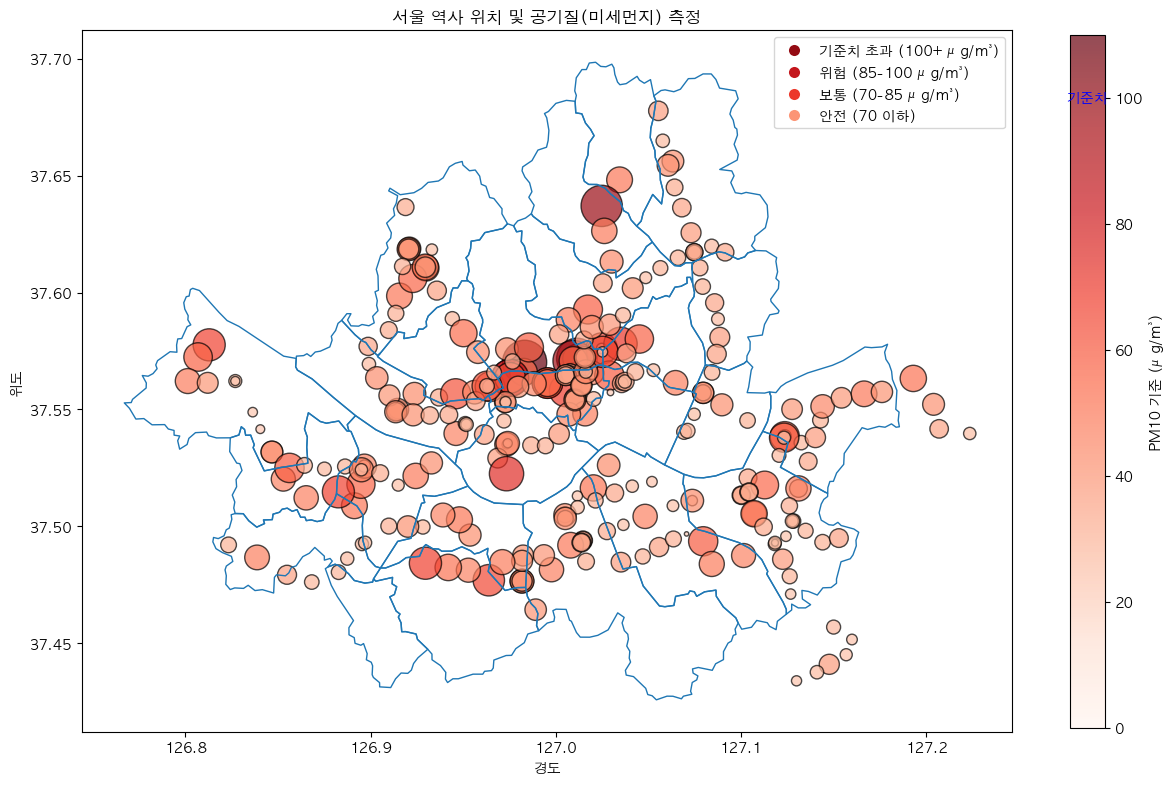

In [6]:
# 한글 폰트 설정 (AppleGothic 사용)
plt.rcParams['font.family'] = 'AppleGothic'

# 한글 폰트 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

# matplotlib을 사용하여 시각화
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

# 서울시 경계선 그리기
seoul_gdf.boundary.plot(ax=ax, linewidth=1)

# 동그라미 크기와 색상을 위한 설정
sizes = 150  # 동그라미 크기
colors = merged_df['미세먼지']
min_pm = colors.min()
max_pm = colors.max()
sizes = 10 + ((colors - min_pm) / (max_pm - min_pm) * 1000)  # 최소값 10, 최대값 1000으로 조정

norm = mcolors.Normalize(vmin=0, vmax=colors.max())
cmap = cm.Reds

# 지하철역 좌표와 이름 그리기
sc = ax.scatter(merged_df['경도'], merged_df['위도'], c=colors, cmap='Reds', s=sizes, edgecolor='black', alpha=0.7, norm=norm)

# 지하철역 이름 추가
# for i, row in merged_df.iterrows():
#     ax.text(row['경도'], row['위도'], row['역명'], fontsize=9, ha='right')

# 색상바 추가
cbar = plt.colorbar(sc, ax=ax, orientation='vertical', shrink=0.6)
cbar.set_label('PM10 기준 (μg/m³)')

# 100 기준선 추가
# cbar.ax.hlines(100, *cbar.ax.get_xlim(), color='blue', linestyle='--', linewidth=2)
cbar.ax.text(0.5, 100, '기준치', color='blue', va='center', ha='center')

# 미세먼지 수치에 따른 색상 계산
norm = mcolors.Normalize(vmin=0, vmax=colors.max())
cmap = cm.Reds

# 각 구간에 해당하는 색상 지정
color_100_plus = cmap(norm(100))
color_85_100 = cmap(norm(85))
color_70_85 = cmap(norm(70))
color_70_below = cmap(norm(40))

# 범례 추가
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=color_100_plus, markersize=10, label='기준치 초과 (100+ μg/m³)', markeredgewidth=2),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=color_85_100, markersize=10, label='위험 (85-100 μg/m³)', markeredgewidth=2),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=color_70_85, markersize=10, label='보통 (70-85 μg/m³)', markeredgewidth=2),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=color_70_below, markersize=10, label='안전 (70 이하)', markeredgewidth=2)
]
ax.legend(handles=legend_elements, loc='upper right')

# 제목 및 레이블 설정
plt.title('서울 역사 위치 및 공기질(미세먼지) 측정')
plt.xlabel('경도')
plt.ylabel('위도')

# 시각화 결과 저장
plt.savefig('seoul_subway_air_quality.png')
plt.show()